In [1]:
import numpy
import h5py
import time
import os, sys
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import scipy.stats
from scipy.signal import peak_widths

In [2]:
# Set up all the systematic sets
path = '/mnt/scratch/micall12/training_files/'
file1= path + 'Level5p_IC86.2013_genie_nue.012640.300.transformed.hdf5'
file2= path + 'Level5p_IC86.2013_genie_nue.012643.300.lt60_vertexDC.transformed.hdf5' #'Level5_IC86.2013_genie_nue.012643.100.cascade.lt60_vertexDC.transformed.hdf5'
file3= path + 'Level5p_IC86.2013_genie_nue.012663.300.transformed.hdf5'
file4= path + 'Level5p_IC86.2013_genie_nue.012603.300.transformed.hdf5'
file5= path + 'Level5p_IC86.2013_genie_nue.012600.300.transformed.hdf5'
name1= 'baseline (no RDE)' #'12640'
name2= '0.96 DOM eff (no RDE)' #"12643"
name3= '0.96 DOM eff, +10 holeice (no RDE)' #"12663"
name4= '0.96 DOM eff (w/ RDE)' #"12603"
name5='baseline (w/ RDE)' #"12600"

# Pick model to load
model_name=path + 'nue_5p_cascade_allfiles_drop20_model.hdf5'

# Make these match
filelist = [file1, file2, file3, file4, file5]
namelist = [name1, name2, name3, name4, name5]
num_namelist = ["640", "643", "663", "603", "600"]
num_labels=1

#Set up method to save output plots
save = True
save_folder_name = "compare"
numberlist = [12640, 12643, 12663, 12603, 12600]
for a_number in numberlist:
    save_folder_name += "_%s"%a_number
save_folder_name += "/"

In [3]:
index = 0
Y_test = {}
X_test_DC = {}
X_test_IC = {}
reco_test = {}
min_events = None
for file in filelist:
    keyname = "file_%i"%index
    f = h5py.File(file, 'r')
    Y_test[keyname] = f['Y_test'][:]
    X_test_DC[keyname] = f['X_test_DC'][:]
    X_test_IC[keyname] = f['X_test_IC'][:]
    reco_test[keyname] = f['reco_test'][:]
    f.close()
    del f
    
    if not min_events:
        min_events = len(Y_test[keyname])
    else:
        if min_events > len(Y_test[keyname]):
            min_events = len(Y_test[keyname])
        
    #if keyname=='file_0': #only use subset of big 
    #    Y_test[keyname]=Y_test[keyname][:13298]
    #    X_test_DC[keyname]=X_test_DC[keyname][:13298]
    #    X_test_IC[keyname]=X_test_IC[keyname][:13298]
        
    print("Testing set for %s: %i"%(namelist[index], len(Y_test[keyname]) ) )
    index+=1
    
print("Only saving a subset of all the events, using %i"%min_events)
for a_index in range(0,len(namelist)):
    keyname = "file_%i"%a_index
    Y_test[keyname]=Y_test[keyname][:min_events]
    X_test_DC[keyname]=X_test_DC[keyname][:min_events]
    X_test_IC[keyname]=X_test_IC[keyname][:min_events]
    reco_test[keyname] =  reco_test[keyname][:min_events]

Testing set for baseline (no RDE): 28742
Testing set for 0.96 DOM eff (no RDE): 26619
Testing set for 0.96 DOM eff, +10 holeice (no RDE): 28898
Testing set for 0.96 DOM eff (w/ RDE): 33192
Testing set for baseline (w/ RDE): 35992
Only saving a subset of all the events, using 26619


In [4]:
### Build The Network ##

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import initializers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

## MIRCO NETWORK ##

dropout = 0.1
DC_drop_value = dropout
IC_drop_value = dropout
connected_drop_value = dropout

# DEEP CORE #
print("Test Data DC", X_test_DC['file_0'].shape)
strings = X_test_DC['file_0'].shape[1]
dom_per_string = X_test_DC['file_0'].shape[2]
dom_variables = X_test_DC['file_0'].shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
input_DC = Input(shape=(strings, dom_per_string, dom_variables))

conv1_DC = Conv2D(100,kernel_size=(strings,5),padding='same',activation='tanh')(input_DC) #tanh
batch1_DC = BatchNormalization()(conv1_DC)
pool1_DC = MaxPooling2D(pool_size=(1,2))(batch1_DC)
drop1_DC = Dropout(DC_drop_value)(pool1_DC)

conv2_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop1_DC) #relu
batch2_DC = BatchNormalization()(conv2_DC)
drop2_DC = Dropout(DC_drop_value)(batch2_DC)

conv3_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop2_DC)
batch3_DC = BatchNormalization()(conv3_DC)
drop3_DC = Dropout(DC_drop_value)(batch3_DC)

conv4_DC = Conv2D(100,kernel_size=(strings,3),padding='valid',activation='relu')(drop3_DC)
batch4_DC = BatchNormalization()(conv4_DC)
pool4_DC = MaxPooling2D(pool_size=(1,2))(batch4_DC)
drop4_DC = Dropout(DC_drop_value)(pool4_DC)

conv5_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_DC)
batch5_DC = BatchNormalization()(conv5_DC)
drop5_DC = Dropout(DC_drop_value)(batch5_DC)

conv6_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_DC)
batch6_DC = BatchNormalization()(conv6_DC)
drop6_DC = Dropout(DC_drop_value)(batch6_DC)

conv7_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_DC)
batch7_DC = BatchNormalization()(conv7_DC)
drop7_DC = Dropout(DC_drop_value)(batch7_DC)

conv8_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_DC)
batch8_DC = BatchNormalization()(conv8_DC)
drop8_DC = Dropout(DC_drop_value)(batch8_DC)

flat_DC = Flatten()(drop8_DC)


# ICECUBE NEAR DEEPCORE #
print("Train Data IC", X_test_IC['file_0'].shape)
strings_IC = X_test_IC['file_0'].shape[1]
dom_per_string_IC = X_test_IC['file_0'].shape[2]
dom_variables_IC = X_test_IC['file_0'].shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
input_IC = Input(shape=(strings_IC, dom_per_string_IC, dom_variables_IC))

conv1_IC = Conv2D(100,kernel_size=(strings_IC,5),padding='same',activation='tanh')(input_IC)
batch1_IC = BatchNormalization()(conv1_IC)
pool1_IC = MaxPooling2D(pool_size=(1,2))(batch1_IC)
drop1_IC = Dropout(IC_drop_value)(pool1_IC)

conv2_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop1_IC)
batch2_IC = BatchNormalization()(conv2_IC)
drop2_IC = Dropout(IC_drop_value)(batch2_IC)

conv3_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop2_IC)
batch3_IC = BatchNormalization()(conv3_IC)
drop3_IC = Dropout(IC_drop_value)(batch3_IC)

conv4_IC = Conv2D(100,kernel_size=(strings_IC,3),padding='valid',activation='relu')(drop3_IC)
batch4_IC = BatchNormalization()(conv4_IC)
pool4_IC = MaxPooling2D(pool_size=(1,2))(batch4_IC)
drop4_IC = Dropout(IC_drop_value)(pool4_IC)

conv5_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_IC)
batch5_IC = BatchNormalization()(conv5_IC)
drop5_IC = Dropout(IC_drop_value)(batch5_IC)

conv6_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_IC)
batch6_IC = BatchNormalization()(conv6_IC)
drop6_IC = Dropout(IC_drop_value)(batch6_IC)

conv7_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_IC)
batch7_IC = BatchNormalization()(conv7_IC)
drop7_IC = Dropout(IC_drop_value)(batch7_IC)

conv8_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_IC)
batch8_IC = BatchNormalization()(conv8_IC)
drop8_IC = Dropout(IC_drop_value)(batch8_IC)

flat_IC = Flatten()(drop8_IC)

# PUT TOGETHER #
concatted = concatenate([flat_DC, flat_IC])

full1 = Dense(300,activation='relu')(concatted)
batch1_full = BatchNormalization()(full1)
dropf = Dropout(connected_drop_value)(batch1_full)

output = Dense(num_labels,activation='linear')(dropf)
lambda_layer = Lambda(lambda x: (x*335)/1.)(output)
model_DC = Model(inputs=[input_DC,input_IC],outputs=lambda_layer)

Using TensorFlow backend.


('Test Data DC', (26619, 8, 60, 5))
('Train Data IC', (26619, 7, 60, 5))


In [5]:
## Compile ##
model_DC.compile(loss='mean_squared_error',
              optimizer=Adam(lr=1e-3), #0.00001
              metrics=['mean_squared_error'])

In [6]:
print(model_name)
model_DC.load_weights(model_name)

/mnt/scratch/micall12/training_files/nue_5p_cascade_allfiles_drop20_model.hdf5


In [7]:
#ENERGY
def plot_prediction(Y_test, Y_test_predicted,save=False,savefolder=None,syst_set=""):
    """
    Plot testing set prediction vs truth and fractional error
    Recieves:
        Y_test = array, Y_test truth
        Y_test_prediction = array, neural network prediction output
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        two plots, saved to files
    """
    plt.figure(figsize=(10,7))
    cts,xbin,ybin,img = plt.hist2d(Y_test, Y_test_predicted, bins=60,)
    plt.plot([0,60],[0,60],'k:')
    plt.xlim(0,60)
    plt.ylim(0,60)
    plt.xlabel("True Energy (GeV)")
    plt.ylabel("NN Predicted Energy (GeV)")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    plt.set_cmap('viridis_r')
    plt.title("Reconstruction (from NN) vs Truth for Energy")
    if save == True:
        plt.savefig("%senergy_prediction_truth%s.png"%(savefolder,syst_set))

    fractional_error = abs(Y_test - Y_test_predicted)/ Y_test
    plt.figure(figsize=(10,7))
    plt.title("Fractional Error vs. Energy")
    plt.hist2d(Y_test, fractional_error,bins=60);
    plt.xlabel("True Energy")
    plt.ylabel("Fractional Error")
    #plt.ylim(0,0.5)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    if save == True:
        plt.savefig("%sFractionalError%s.png"%(savefolder,syst_set))


In [8]:
def get_RMS(resolution):
    mean_array = numpy.ones_like(resolution)*numpy.mean(resolution)
    rms = numpy.sqrt( sum((mean_array - resolution)**2)/len(resolution) )
    return rms

def get_FWHM(resolution,bins):
    #FWHM
    x_range = numpy.linspace(min(resolution),max(resolution),bins)
    y_values,bin_edges = numpy.histogram(resolution,bins=bins)
    spline = UnivariateSpline(x_range,y_values - max(y_values)/2.)
    r = spline.roots()
    if len(r) != 2:
        print("Root are weird")
        print(r)
        r1 = 0
        r2 = 0
    else:
        r1, r2 = spline.roots()
    return r1, r2

In [9]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

def plot_distributions(Y_test,Y_test_predicted,namelist,save_folder_name,save=False):
    
    if Y_test is dict:
        
        plt.figure()
        plt.title("True Energy Distribution")
        for index in range(0,len(namelist)):
            keyname = "file_%i"%index
            plt.hist(Y_test[keyname], bins=100,alpha=0.5,label="%s"%namelist[index]);
        plt.legend()

        plt.figure()
        plt.title("NN Energy Distribution")
        for index in range(0,len(filelist)):
            plt.hist(Y_test_predicted[index], bins=100,color='b', alpha=0.5, label="%s"%namelist[index]);
        plt.legend()
    
    else:
        plt.figure()
        plt.title("True Energy Distribution")
        plt.hist(Y_test, bins=100,alpha=0.5,label="%s"%namelist);
        plt.legend()

        plt.figure()
        plt.title("NN Energy Distribution")
        plt.hist(Y_test_predicted, bins=100,color='b', alpha=0.5, label="%s"%namelist);
        plt.legend()

def plot_resolution(truth,predicted,namelist, save_folder_name, num_namelist = None,save=False,bins=100):
    """Plots resolution for dict of inputs
    truth = dict of truth or Y_test labels
    predicted = dict of predicted or Y_test_predicted results
    namelist = list of names for the dict, to use as pretty labels
    save_folder_name = string for output file
    save = bool where True saves and False does not save plot
    bins = int value
    """
    print("Energy")
    print('Name\t Mean\t Median\t RMS\t Percentiles\t')
    plt.figure(figsize=(10,7))  
    plt.title('Energy Resolution')
    for index in range(0,len(namelist)):
        keyname = "file_%i"%index
        resolution = predicted[keyname] - truth[keyname]
        plt.hist(resolution, bins=60, alpha=0.5, label="%s"%namelist[index]);
        
        #Statistics
        rms = get_RMS(resolution)
        #r1, r2 = get_FWHM(resolution,bins)
        r1, r2 = numpy.percentile(resolution, [16,84])
        
        if num_namelist:
            names = num_namelist
        else:
            names = namelist
            
        print("%s\t %.2f\t %.2f\t %.2f\t %.2f, %.2f\t"%(names[index], \
                                                            numpy.mean(resolution), \
                                                            numpy.median(resolution), \
                                                            rms, \
                                                            r1, r2))
        
    plt.xlabel("NN reconstruction - truth (GeV)")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
    if save:
        plt.savefig("%sEnergyResolution.png"%save_folder_name)
        
    print("Fractional Resolution")
    print('Name\t Mean\t Median\t RMS\t Percentiles\t')
    plt.figure(figsize=(10,7))  
    plt.title("Fractional Energy Resolution")
    for index in range(0,len(namelist)):
        keyname = "file_%i"%index
        resolution_fraction = (predicted[keyname] - truth[keyname])/truth[keyname]
        plt.hist(resolution_fraction, bins=bins, alpha=0.5, label="%s"%namelist[index]);
        
        #Statistics
        rms_frac = get_RMS(resolution_fraction)
        #r1_frac, r2_frac = get_FWHM(resolution_fraction,bins)
        r1_frac, r2_frac = numpy.percentile(resolution_fraction, [16,84])
        
        print("%s\t %.2f\t %.2f\t %.2f\t %.2f, %.2f\t"%(names[index], \
                                                            numpy.mean(resolution_fraction), \
                                                            numpy.median(resolution_fraction), \
                                                            rms_frac, \
                                                            r1_frac, r2_frac))
        
    plt.xlabel("(NN reconstruction - truth) / truth")
    plt.legend(fontsize=20)
    if save:
        plt.savefig("%sFractionalEnergyResolution.png"%save_folder_name)



In [10]:
def plot_single_resolution(truth,predicted,a_name,save_folder_name,save=False,bins=100,fraction=False,energy_min=None,energy_max=None):
    """Plots resolution for dict of inputs
    truth = dict of truth or Y_test labels
    predicted = dict of predicted or Y_test_predicted results
    namelist = list of names for the dict, to use as pretty labels
    save_folder_name = string for output file
    save = bool where True saves and False does not save plot
    bins = int value
    """
    fig, ax = plt.subplots(figsize=(10,7)) 
    if fraction:
        resolution = (predicted - truth)/truth
        title = "Fractional Energy Resolution"
        xlabel = "(NN reconstruction - truth) / truth"
    else:
        resolution = predicted - truth
        title = "Energy Resolution"
        xlabel = "NN reconstruction - truth (GeV)"
    
    
    if energy_min or energy_max:
        if energy_min and energy_max:
            energy_mask = numpy.logical_and(truth > energy_min, truth < energy_max)
            title += " (%.2f < energy < %.2f)"%(energy_min,energy_max)
        if energy_min and not energy_max:
            energy_mask = truth > energy_min
            title += " (energy > %.2f)"%(energy_min)
        if energy_max and not energy_min:
            energy_mask = truth < energy_max
            title += " (energy < %.2f)"%(energy_max)
    
        ax.hist(resolution[energy_mask], bins=bins, alpha=0.5, label="%s"%a_name);
        #Statistics
        rms = get_RMS(resolution[energy_mask])
        #r1, r2 = get_FWHM(resolution[energy_mask],bins)
        r1, r2 = numpy.percentile(resolution[energy_mask], [16,84])
        
        textstr = '\n'.join((
            r'$\mathrm{events}=%i$' % (numpy.sum(resolution[energy_mask]), ),
            r'$\mathrm{median}=%.2f$' % (numpy.median(resolution[energy_mask]), ),
            r'$\mathrm{RMS}=%.2f$' % (rms, )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)
            
    else:
        ax.hist(resolution, bins=bins, alpha=0.5, label="%s"%a_name);
        #Statistics
        rms = get_RMS(resolution)
        r1, r2 = get_FWHM(resolution,bins)
        
        ax.plot([r1,r1],[0,600],color='g',linewidth=2,label="Percentile 16")
        ax.plot([r2,r2],[0,600],color='g',linewidth=2,label="Percentile 84")
        ax.plot([numpy.median(resolution),numpy.median(resolution)],[0,700],color='k',linestyle='--',linewidth=2,label='mean')

        textstr = '\n'.join((
            r'$\mathrm{events}=%i$' % (len(resolution), ),
            r'$\mathrm{mean}=%.2f$' % (numpy.mean(resolution), ),
            r'$\mathrm{median}=%.2f$' % (numpy.median(resolution), ),
            r'$\mathrm{RMS}=%.2f$' % (rms, ),
            r'$\mathrm{FWHM}=%.2f,%.2f$' % (r1,r2, )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        if fraction:
            ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)
        else:
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if save and fraction:
        plt.savefig("%sFractionalEnergyResolution.png"%save_folder_name)
    elif save and not fraction:
        plt.savefig("%sEnergyResolution.png"%save_folder_name)

    print(numpy.mean(resolution),rms,r1,r2)

In [11]:
def plot_single_resolution_vs_reco(truth,predicted,reco,a_name,save_folder_name,save=False,bins=100,fraction=False,energy_min=None,energy_max=None):
    """Plots resolution for dict of inputs
    truth = array of truth or Y_test labels
    predicted = array of predicted or Y_test_predicted results
    reco = pegleg array of labels
    name = name of set to use as pretty labels
    save_folder_name = string for output file
    save = bool where True saves and False does not save plot
    bins = int value
    """
    fig, ax = plt.subplots(figsize=(10,7)) 
    if fraction:
        resolution = (predicted - truth)/truth
        reco_res = (predicted - reco)/truth
        title = "Fractional Energy Resolution"
        xlabel = "(reconstruction - truth) / truth" 
    else:
        resolution = predicted - truth
        reco_res = predicted - reco
        title = "Energy Resolution"
        xlabel = "reconstruction - truth (GeV)"
    
    if energy_min or energy_max:
        if energy_min and energy_max:
            energy_mask = numpy.logical_and(truth > energy_min, truth < energy_max)
            title += " (%.2f < energy < %.2f)"%(energy_min,energy_max)
        if energy_min and not energy_max:
            energy_mask = truth > energy_min
            title += " (energy > %.2f)"%(energy_min)
        if energy_max and not energy_min:
            energy_mask = truth < energy_max
            title += " (energy < %.2f)"%(energy_max)
    
        new_resolution = resolution[energy_mask]
        new_reco = reco_res[energy_mask]
    else:
        new_resolution = resolution
        new_reco = reco_res
    
    ax.hist(new_resolution, bins=bins, alpha=0.5, label="neural net");
    ax.hist(new_reco, bins=bins, alpha=0.5, label="pegleg");
    #Statistics
    rms = get_RMS(new_resolution)
    #r1, r2 = get_FWHM(new_resolution,bins)
    r1, r2 = numpy.percentile(new_resolution, [16,84])
    r1_reco, r2_reco = numpy.percentile(new_reco, [16,84])
        
    textstr = '\n'.join((
            r'$\mathrm{events}=%i$' % (numpy.sum(new_resolution), ),
            r'$\mathrm{median}=%.2f$' % (numpy.median(new_resolution), ),
            r'$\mathrm{RMS}=%.2f$' % (rms, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
    
    textstr = '\n'.join((
            r'$\mathrm{events}=%i$' % (numpy.sum(new_reco), ),
            r'$\mathrm{median}=%.2f$' % (numpy.median(new_reco), ),
            r'$\mathrm{RMS}=%.2f$' % (rms_reco, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.2, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
    
    print(r1,r2,r1_reco,r2_reco)

In [12]:
def percentiles_slices(true_energy_dict, predicted_energy_dict, namelist, use_fraction=False, use_reco_bool = False, reco_energy_dict=None):

    number_files = len(namelist)
    percentile_in_peak = 68.27

    left_tail_percentile  = (100.-percentile_in_peak)/2
    right_tail_percentile = 100.-left_tail_percentile
    
    medians  = numpy.zeros(number_files)
    err_from = numpy.zeros(number_files)
    err_to   = numpy.zeros(number_files)
    
    if use_reco_bool:
        medians_reco  = numpy.zeros(number_files)
        err_from_reco = numpy.zeros(number_files)
        err_to_reco   = numpy.zeros(number_files)
    
    resolution_fraction = {}
    for index in range(0,number_files):
        keyname = "file_%i"%index
        if use_fraction:
            resolution = (predicted_energy_dict[keyname] - true_energy_dict[keyname])/true_energy_dict[keyname]
        else:
            resolution = (predicted_energy_dict[keyname] - true_energy_dict[keyname])
    
        lower_lim = numpy.percentile(resolution, left_tail_percentile)
        upper_lim = numpy.percentile(resolution, right_tail_percentile)
        median = numpy.percentile(resolution, 50.)
        print(median,numpy.median(resolution))
        
        medians[index] = median
        err_from[index] = lower_lim
        err_to[index] = upper_lim
    
    
        if use_reco_bool:
            if use_fraction:
                resolution_reco = ((reco_energy_dict[keyname]-true_energy_dict[keyname])/true_energy_dict[keyname])
            else:
                resolution_reco = (reco_energy_dict[keyname]-true_energy_dict[keyname])
            
            lower_lim_reco = numpy.percentile(resolution_reco, left_tail_percentile)
            upper_lim_reco = numpy.percentile(resolution_reco, right_tail_percentile)
            median_reco = numpy.percentile(resolution_reco, 50.)
            
            print(median_reco,numpy.median(resolution_reco))
            medians_reco[index] = median_reco
            err_from_reco[index] = lower_lim_reco
            err_to_reco[index] = upper_lim_reco


    x_range = numpy.linspace(1,number_files,number_files)
    
    
    fig, ax = plt.subplots(figsize=(10,7))
    plt.errorbar(x_range, medians, yerr=[medians-err_from, err_to-medians],  capsize=5.0, fmt='o',label="NN Reco")
    if use_reco_bool:
        plt.errorbar(x_range, medians_reco, yerr=[medians_reco-err_from_reco, err_to_reco-medians_reco], capsize=5.0,fmt='o',label="Pegleg Reco")
        plt.legend(loc="upper right")
    ax.plot([0,number_files+1], [0,0], color='k')
    ax.set_xlim(0,number_files+1)
    
    #rename axis
    my_xlabels = [item.get_text() for item in ax.get_xticklabels()]
    new_namelist = [" "] + namelist
    for index in range(0,number_files+1):
        my_xlabels[index] = new_namelist[index]
    ax.set_xticklabels(my_xlabels)
    
    ax.set_xlabel("Systematic Set")
    if use_fraction:
        ax.set_ylabel("Fractional Resolution: \n (reconstruction - truth)/truth")
    else:
        ax.set_ylabel("Resolution: \n reconstruction - truth (GeV)")
    ax.set_title("Resolution Energy Dependence")

In [13]:
Y_test_predicted_energy = {}
Y_test_energy = {}
Y_test_energy_reco = {}
for index in range(0,len(filelist)):
    keyname = "file_%i"%index
    t0 = time.time()
    Y_test_predicted = model_DC.predict([X_test_DC[keyname],X_test_IC[keyname]])
    t1 = time.time()
    Y_test_predicted_energy[keyname] = numpy.reshape(Y_test_predicted, len(Y_test_predicted))
    Y_test_energy[keyname] = numpy.reshape(Y_test[keyname][:,0], len(Y_test[keyname])) 
    Y_test_energy_reco[keyname] = numpy.reshape(reco_test[keyname][:,0], len(reco_test[keyname])) 
    
    
    print("This took me %f minutes for %i events"%(((t1-t0)/60.),len(Y_test_predicted)))

This took me 0.948089 minutes for 26619 events
This took me 0.938765 minutes for 26619 events
This took me 0.934073 minutes for 26619 events
This took me 0.939606 minutes for 26619 events
This took me 0.976912 minutes for 26619 events


In [14]:
# SAVING 
print(save_folder_name)
if save==True:
    if os.path.isdir(save_folder_name) != True:
        os.mkdir(save_folder_name)
    #file = open("%soutput.txt"%save_folder_name,"w")
    #file.write("testing on {} samples".format(len(Y_test)))
    #file.write("final score on test data: loss: {:.4f} / accuracy: {:.4f}\n".format(score[0], score[1]))
    #file.write("This took %f minutes"%((t1-t0)/60.))
    #file.close()


compare_12640_12643_12663_12603_12600/


/mnt/home/micall12/anaconda2/envs/python-tfcpu/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


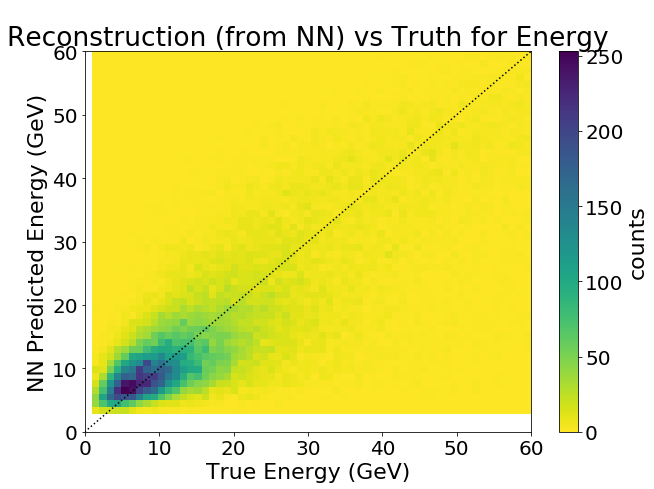

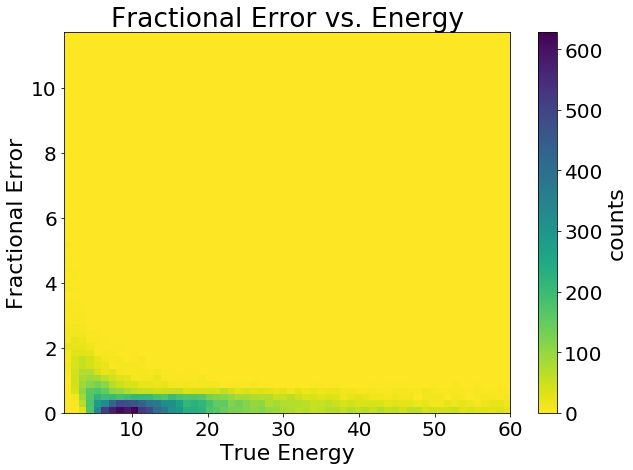

In [15]:
plot_prediction(Y_test_energy['file_0'], Y_test_predicted_energy['file_0'],save,save_folder_name)

Energy
Name	 Mean	 Median	 RMS	 Percentiles	
640	 -0.90	 -0.02	 7.40	 -6.65, 4.90	
643	 -1.69	 -0.53	 7.59	 -7.71, 4.25	
663	 -0.82	 0.09	 7.26	 -6.37, 4.80	
603	 -2.29	 -1.03	 8.03	 -8.85, 4.06	
600	 -1.46	 -0.33	 7.82	 -7.71, 4.60	
Fractional Resolution
Name	 Mean	 Median	 RMS	 Percentiles	
640	 0.12	 -0.00	 0.60	 -0.35, 0.56	
643	 0.07	 -0.04	 0.56	 -0.39, 0.48	
663	 0.12	 0.01	 0.57	 -0.34, 0.55	
603	 0.03	 -0.07	 0.54	 -0.40, 0.43	
600	 0.09	 -0.03	 0.56	 -0.37, 0.50	


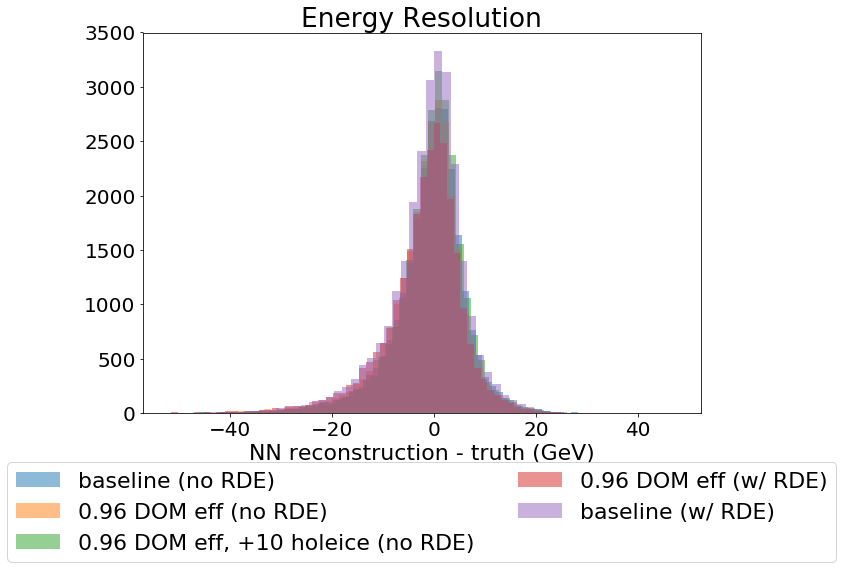

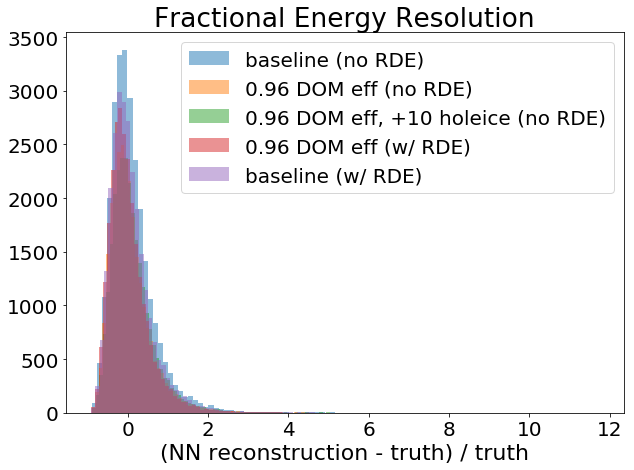

In [16]:
plot_resolution(Y_test_energy,Y_test_predicted_energy, namelist, save_folder_name ,num_namelist,save=True)

(-0.8971338, 7.403833967415429, -4.235096443559176, 5.567536124695381)
(0.121936515, 0.5969318215130786, -0.5451493652193155, 0.31312516644747074)


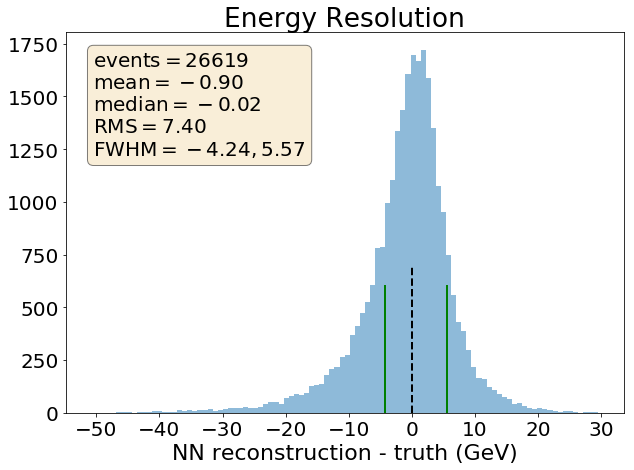

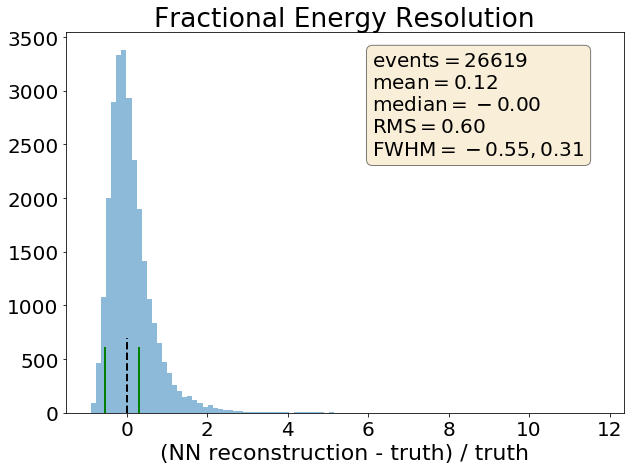

In [17]:
plot_single_resolution(Y_test_energy['file_0'],Y_test_predicted_energy['file_0'], namelist[0], save_folder_name,save=True)
plot_single_resolution(Y_test_energy['file_0'],Y_test_predicted_energy['file_0'], namelist[0], save_folder_name,save=True,fraction=True)

(-0.0161285400390625, -0.01612854)
(-0.5323948860168457, -0.5323949)
(0.09084892272949219, 0.09084892)
(-1.0314979553222656, -1.031498)
(-0.3325996398925781, -0.33259964)
(-0.0012099137529730797, -0.0012099138)
(-0.04310678690671921, -0.043106787)
(0.007760180160403252, 0.00776018)
(-0.07423067837953568, -0.07423068)
(-0.025062499567866325, -0.0250625)


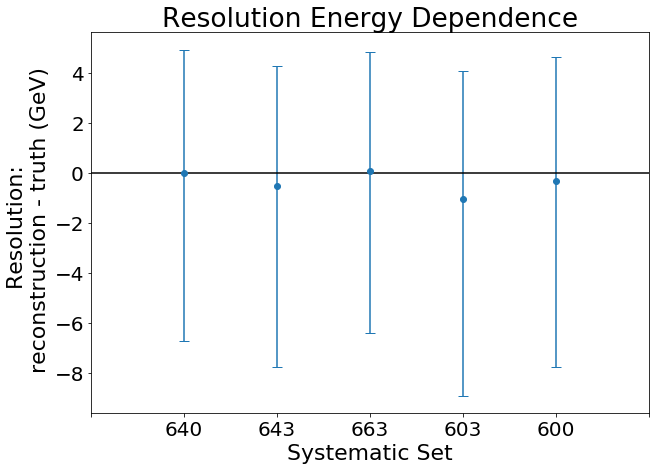

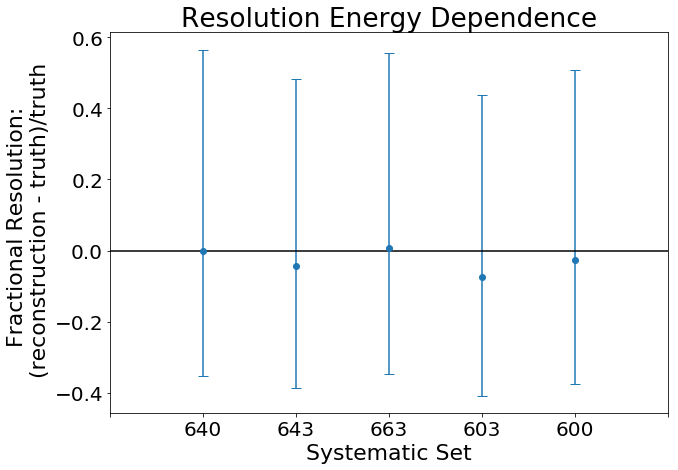

In [18]:
percentiles_slices(Y_test_energy, Y_test_predicted_energy, num_namelist, \
                   use_fraction=False, use_reco_bool = False, reco_energy_dict=None)
percentiles_slices(Y_test_energy, Y_test_predicted_energy, num_namelist,\
                   use_fraction=True, use_reco_bool = False, reco_energy_dict=None)

(-0.0161285400390625, -0.01612854)
(3.042705535888672, 3.0427055)
(-0.5323948860168457, -0.5323949)
(2.4022483825683594, 2.4022484)
(0.09084892272949219, 0.09084892)
(3.1509995460510254, 3.1509995)
(-1.0314979553222656, -1.031498)
(2.3946237564086914, 2.3946238)
(-0.3325996398925781, -0.33259964)
(3.136153221130371, 3.1361532)
(-0.0012099137529730797, -0.0012099138)
(0.2588144540786743, 0.25881445)
(-0.04310678690671921, -0.043106787)
(0.19664303958415985, 0.19664304)
(0.007760180160403252, 0.00776018)
(0.2771146297454834, 0.27711463)
(-0.07423067837953568, -0.07423068)
(0.1832340508699417, 0.18323405)
(-0.025062499567866325, -0.0250625)
(0.24628329277038574, 0.2462833)


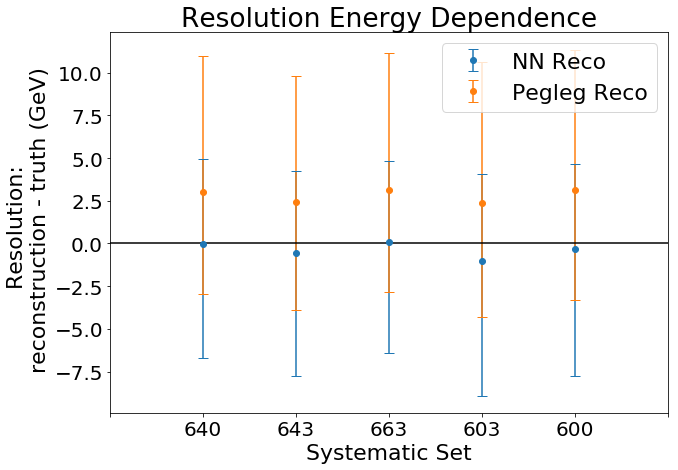

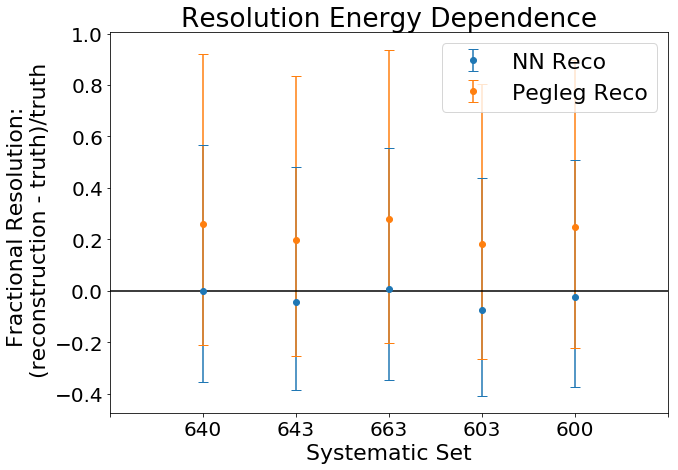

In [19]:
percentiles_slices(Y_test_energy, Y_test_predicted_energy, num_namelist,\
                   use_fraction=False, use_reco_bool = True, reco_energy_dict=Y_test_energy_reco)
percentiles_slices(Y_test_energy, Y_test_predicted_energy, num_namelist,\
                   use_fraction=True, use_reco_bool = True, reco_energy_dict=Y_test_energy_reco)